In [2]:
import numpy as np
import pandas as pd
import random
import math
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [3]:
data = np.array(pd.read_excel("../dataSet/dis_acs.xlsx",header=None))
dist = squareform(pdist(data, metric='euclidean'))

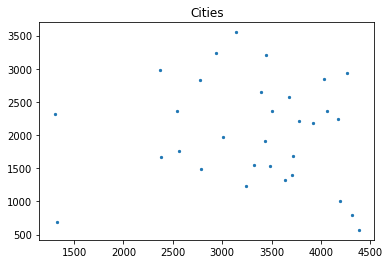

In [10]:
plt.title("Cities")
plt.scatter(data[:,0],data[:,1],s=5)
plt.show()

In [21]:
class ACS():
    def __init__(self, data, m, rho, q0, max_epoch = 1000, alpha = 1, beta = 2):
        self.cityNum = data.shape[0]
        self.dist = self.getDist(data) # 计算N个城市的距离矩阵
        self.m   = m    # 蚂蚁数目
        self.q0  = q0   # 伪随机因子
        self.rho = rho  # 信息素挥发因子 
        self.alpha = alpha  #信息素权重 
        self.beta  = beta   #启发式信息权重     
        self.max_epoch = max_epoch #最大迭代次数
        self.setinitTau()
        
    def getDist(self, data):  # 计算N个城市的距离矩阵
        dist = squareform(pdist(data, metric='euclidean')) 
        i = list(range(self.cityNum))
        dist[i,i] = float('inf')
        return dist
    
    def setinitTau(self):
        s = random.sample(range(self.cityNum), 1) # 开始位置
        j = None # 下一个城市
        sumdist = 0 # 总路程 
        # 贪心
        for i in range(self.cityNum):
            temp = float('inf')
            for k in range(self.cityNum):
                if k not in s and dist[k, s[i]] < temp:
                    temp = dist[k, s[i]]
                    j = k
            if j not in s:
                s.append(j)
                sumdist += temp
        sumdist += dist[s[0], j] #回到原处
        self.tau = np.ones((self.cityNum, self.cityNum)) * (self.m / sumdist)
        i = list(range(self.cityNum))
        self.tau[i,i] = 0
        return
    
    def select(self, pk, jk): #伪随机比例规则 （开发+偏向探索）
        nextCityIndex = None
        q = random.uniform(0, 1)
        if q <= self.q0:
            nextCityIndex = np.argmax(pk)
        else:
            if np.sum(pk) < 1e-15:         
                p = [1 for _ in range(len(jk))]
            else:
                p = pk / np.sum(pk)
            m = 0
            r = random.uniform(0, 1)
            for i, j in enumerate(p):
                m += j
                if r <= m:
                    nextCityIndex = i
                    break
        return jk[nextCityIndex]

    def antsMove(self):
        paths = dict()
        for k in range(self.m): # 所有蚂蚁
            rk = random.sample(range(self.cityNum), 1) # 设置路径列表 并初始随机开始位置 
            sumdist = 0  # 路径长度和
            for c in range(self.cityNum-1):
                jk = list(set(range(self.cityNum)).difference(set(rk)))  # 差集
                pk = [0 for _ in range(len(jk))]  # 概率列表
                for i, j in enumerate(jk):
                    pk[i] = np.power(self.tau[rk[-1], j], self.alpha) * np.power((1 / self.dist[rk[-1], j]), self.beta)  # 伪随机比例
                nextCity = self.select(pk, jk)  # 轮盘赌选择下一个城市
                sumdist += self.dist[rk[-1], nextCity]  
                rk.append(nextCity)
            sumdist += self.dist[rk[0], rk[-1]]  # 回到原来城市
            rk.append(rk[0]) # 添加原来城市
            paths[(k, sumdist)] = rk  # <蚂蚁编号，路径长度>:<路径>
        return paths

    def updateTau(self, paths):
        for i in range(self.cityNum): 
            for j in range(self.cityNum):
                if i != j:  # 非对角线边
                    sigma = 0  #信息素增量
                    for ksumdist, path in paths.items(): 
                        sumdist = ksumdist[1]
                        index = path.index(i)
                        if index + 1 < self.cityNum and path[index + 1] == j: # 判断路径是否包含边
                            sigma += 1/sumdist
                    self.tau[i, j] = (1 - self.rho) * self.tau[i, j] + sigma  # 更新信息素量tau
        return
    
    def getMinRoute(self, paths):  # 获取最优解和最优值 + 格式化输出
        mindist = float('inf')
        key = None 
        for ksumdist in paths.keys():
            if ksumdist[1] < mindist:
                mindist = ksumdist[1]
                key = ksumdist
        return (key[1], paths[key])
    
    def evolute(self):  #演化过程
        paths = None
        eopch = None
        for t in range(1, self.max_epoch+1):
            paths = self.antsMove()  # 蚂蚁的一轮移动
            flag = 0
            sumdist = 0
            for ksumdist in paths.keys():
                if flag == 0:
                    sumdist = ksumdist[1]
                    flag += 1
                else:
                    if abs(sumdist - ksumdist[1]) < 1e-5:
                        flag += 1
            if flag/self.m >= 0.9:
                break
            self.updateTau(paths)  #更新信息素量tau值
        print('总计迭代:',str(t),'次')
        res = self.getMinRoute(paths)
        print('最优值:',res[0])
        print('最优解:',res[1])
        return t, res
            

In [78]:
m = 10    # 蚂蚁数目
rho = 0.5 # 信息素挥发因子 
q0  = 0.2 # 伪随机因子
max_epoch = 1000
acs = ACS(data, m, rho, q0, max_epoch)
t, paths = acs.evolute()

总计迭代: 1000 次
最优值: 18636.405227075655
最优解: [25, 27, 26, 29, 30, 28, 11, 13, 12, 6, 3, 1, 4, 5, 10, 22, 15, 16, 18, 23, 19, 24, 0, 14, 8, 9, 7, 17, 2, 21, 20, 25]


'\nfileName = "%s%s%s" %("最短路径",str(paths[0]),".png")\nplt.savefig(fileName)\nplt.show()'

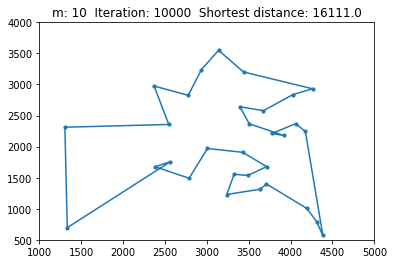

In [77]:
plt.title("m: "+str(m)+"  Iteration: "+str(t)+"  Shortest distance: "+ str(round(paths[0])))
plt.xlim(1000,5000)
plt.ylim(500,4000)
plt.scatter(data[:,0],data[:,1],s=10)
plt.plot(data[paths[1],0],data[paths[1],1])
'''
fileName = "%s%s%s" %("最短路径",str(paths[0]),".png")
plt.savefig(fileName)
plt.show()'''